<a href="https://colab.research.google.com/github/NILEG/TensorFlow/blob/main/Statistical_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

####Types of Pattern

1. Trends
2. Seasonality
3. Noise
4. Auto-correlation
5. Non-stationary Series


####Plotting Function

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

####Data Generators

In [4]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

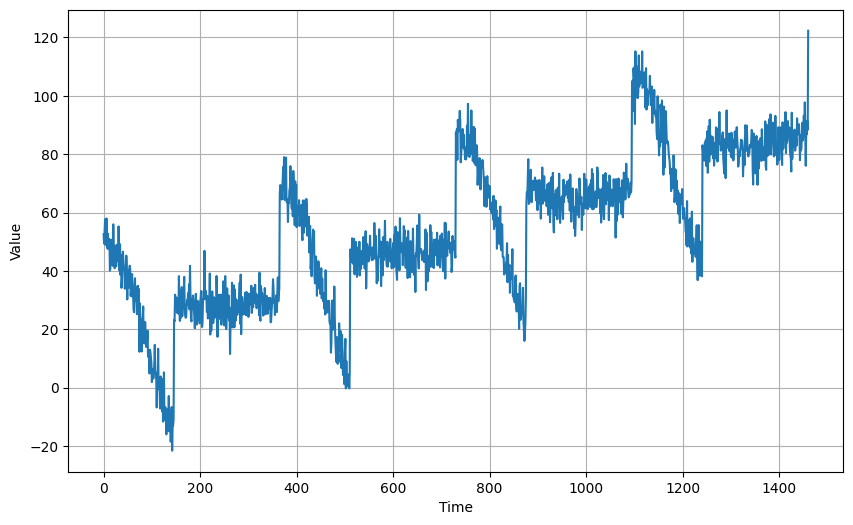

In [5]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

####Splitting Data

In [6]:
train=series[:1000]
test=series[1000:]
print(len(train), len(test))

1000 461


####Types of prediction


1. Naive Prediction
2. Moving Averages
3. Differencing
4. Smoothing



####Naive Prediction

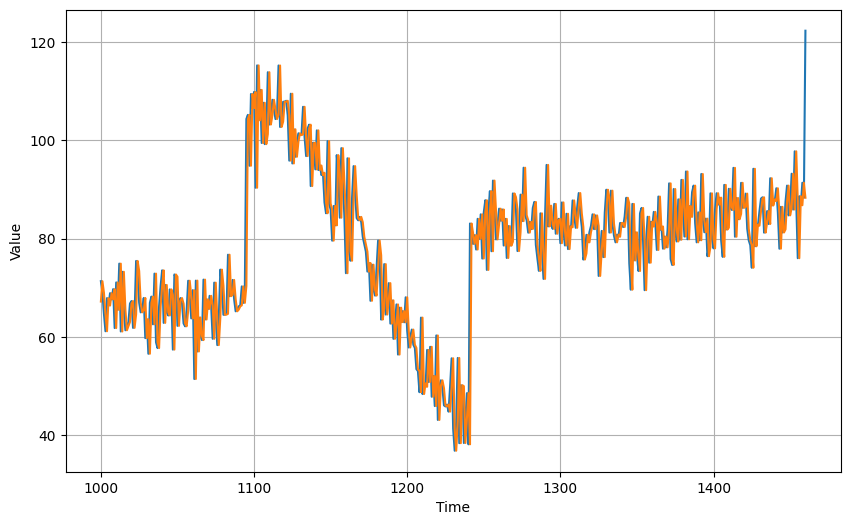

In [7]:
prediction=series[999: -1]
plot_series(time=time[1000:], series=(test, prediction))

In [8]:
tf.keras.metrics.mean_squared_error(test, prediction).numpy()
tf.keras.metrics.mean_absolute_error(test, prediction).numpy()

5.937908

####Moving Averages

In [9]:
def moving_averages(series, window):
  forecasting=[]
  for time in range(len(series)-window):
    forecasting.append(series[time: time+window].mean())
  return np.array(forecasting, dtype=np.float32)

moving_averages(np.arange(100), 10)[:10]

array([ 4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5],
      dtype=float32)

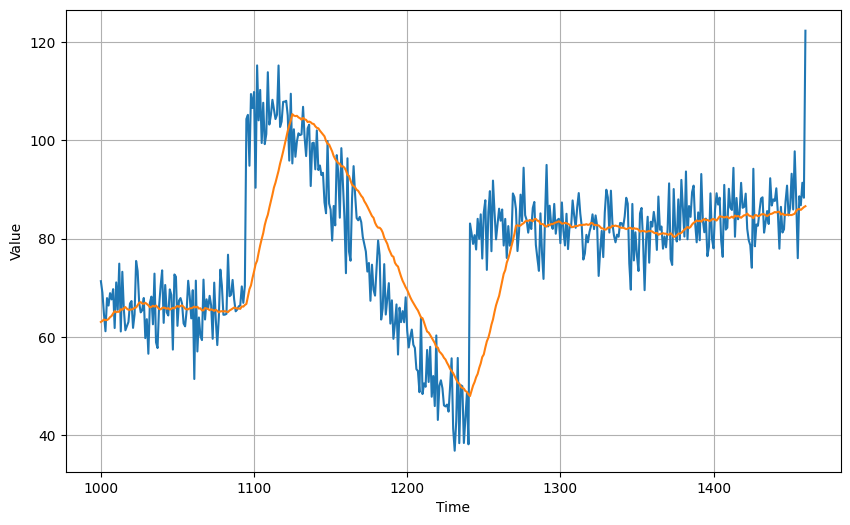

In [10]:
prediction=moving_averages(series, 30)
plot_series(time[1000:], (test, prediction[1000-30:]))

In [11]:
tf.keras.metrics.mean_squared_error(test, prediction[1000-30:]).numpy()
tf.keras.metrics.mean_absolute_error(test, prediction[1000-30:]).numpy()

7.142419

####Differencing

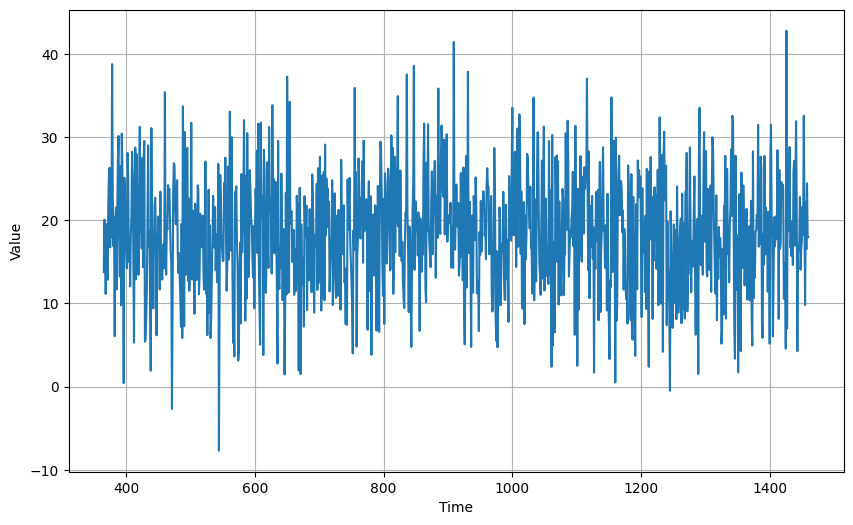

In [12]:
#Differencing
difference=series[365: ]-series[:-365]
plot_series(time[365:], difference)

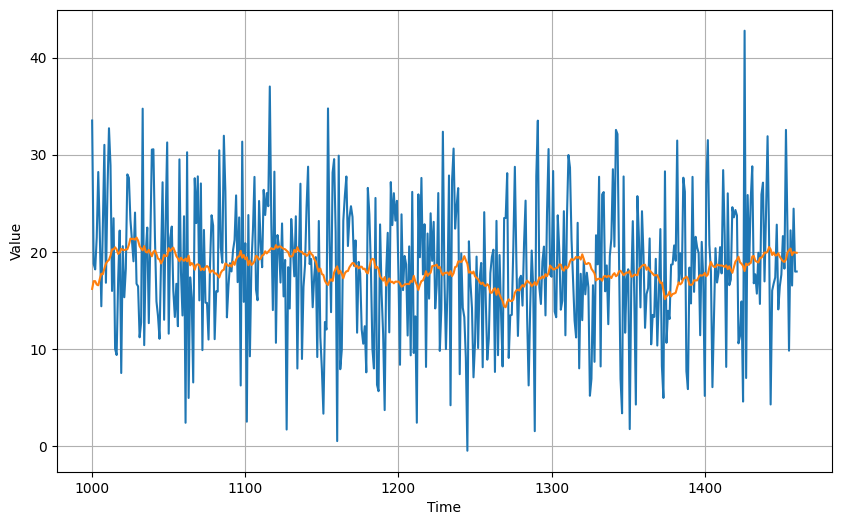

In [13]:
#Moving averages of difference
prediction=moving_averages(difference, 30)
plot_series(time[1000:], (difference[1000-365:], prediction[1000-365-30:]))

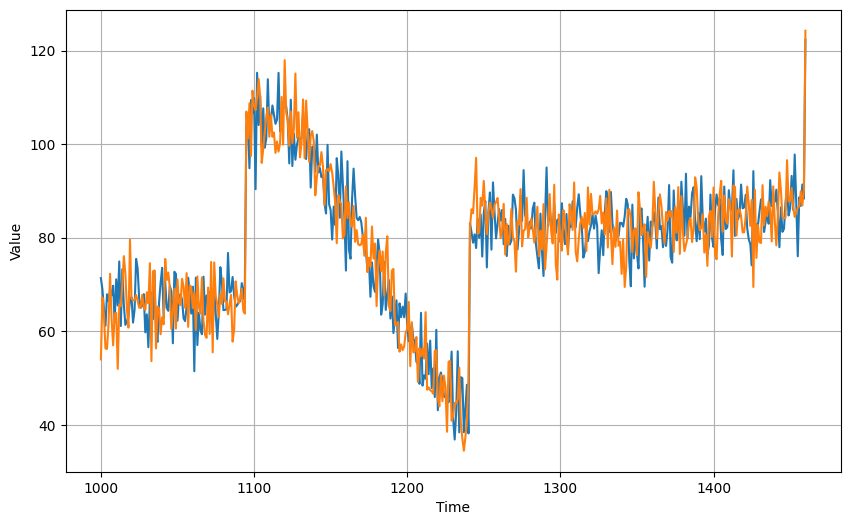

In [14]:
#Adding past values
past_values=series[1000-365:-365]
diff_with_past= prediction[1000-365-30:] + past_values
plot_series(time[1000:], (test, diff_with_past))

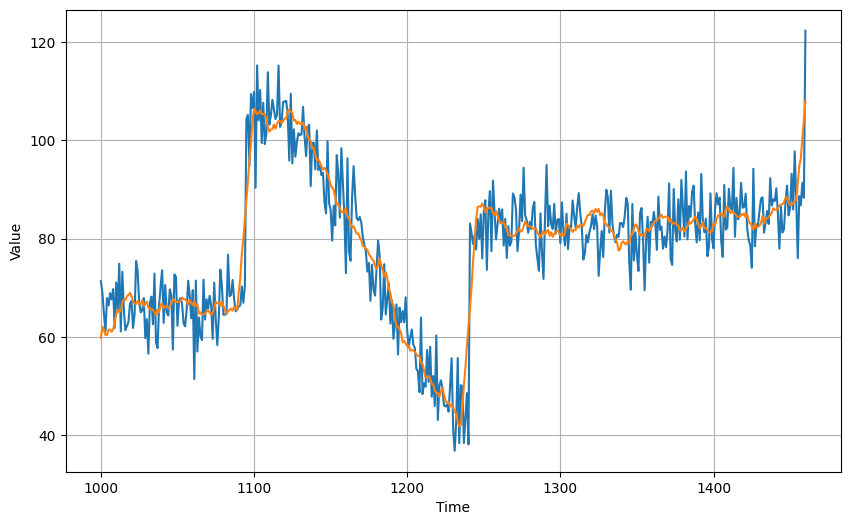

In [28]:
#Smooting the prediction
smooth_diff_with_past=moving_averages(series[1000-370:-359], 11)+prediction[1000-365-30:]
plot_series(time[1000:], (test, smooth_diff_with_past))